In [29]:
import pandas as pd
import pypsa
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [30]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime

# load onshore wind data
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)

# load offshore wind data
df_offshorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)

# load large scale pv data
df_pv = pd.read_csv('data\pv_optimal.csv', sep=';', index_col=0)
df_pv.index = pd.to_datetime(df_pv.index)

# load rooftop pv data
df_rooftop = pd.read_csv('data\pv_rooftop.csv', sep=';', index_col=0)
df_rooftop.index = pd.to_datetime(df_rooftop.index)

# load hydro inflow in Austria
df_hydro = pd.read_csv('data/Hydro_Inflow_AT.csv')  # assumes columns: Year, Month, Day, Inflow [GWh]
df_hydro['date'] = pd.to_datetime(df_hydro[['Year', 'Month', 'Day']])
df_hydro.set_index('date', inplace=True)

# Convert from GWh/day → MW (spread evenly across 24 hours)
df_hydro['inflow_MW'] = df_hydro['Inflow [GWh]'] * 1000 / 24
## Align to model snapshots
df_hydro_hourly = df_hydro['inflow_MW'].resample('H').ffill()


hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

df_hydro_inflow = pd.DataFrame(index=hours_in_2015)
df_hydro_inflow['inflow_MW'] = df_hydro_hourly.loc[df_hydro_hourly.index.year==2011].values

<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Tuferome\AppData\Local\Temp\ipykernel_36256\3096401804.py:14: SyntaxWarning: invalid escape sequence '\p'
  df_pv = pd.read_csv('data\pv_optimal.csv', sep=';', index_col=0)
C:\Users\Tuferome\AppData\Local\Temp\ipykernel_36256\3096401804.py:18: SyntaxWarning: invalid escape sequence '\p'
  df_rooftop = pd.read_csv('data\pv_rooftop.csv', sep=';', index_col=0)
C:\Users\Tuferome\AppData\Local\Temp\ipykernel_36256\3096401804.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hydro_hourly = df_hydro['inflow_MW'].resample('H').ffill()


In [31]:
colors = {"onshore": "blue", "offshore": "darkblue", "pv": "orange", 
          "rooftop": "yellow", "coal": "brown", "OCGT": "grey"}

# __F.__ Make Network

In [32]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [33]:
n = pypsa.Network()
n.set_snapshots(hours_in_2015.values)

# add the different carriers, only gas emits CO2
n.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
n.add("Carrier", "coal", co2_emissions=0.9) # in t_CO2/MWh_th
n.add("Carrier", "onshorewind")
n.add("Carrier", "offshorewind")
n.add("Carrier", "solarPV")
n.add("Carrier", "rooftopPV")
n.add("Carrier", "hydro")

countries = ['DEU', 'DNK', 'AUT']
coordinates = {'DNK': (55.67, 12.57), # Copenhagen
                'DEU': (52.37, 9.73), # Hannover
                'AUT': (47.57, 14.23)} # Liezen

# add electricity bus
for country in countries:
    n.add("Bus",
                country,
                y = coordinates[country][0],
                x = coordinates[country][1],
                carrier="AC",)

    # add load to the bus
    n.add("Load",
                f"load{country}",
                bus=country,
                p_set=df_elec[country].values)


    ''' Add renewable generators '''
    if country != 'AUT':
        # Add onshore wind
        CF_wind_onshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
        lifetime = 30 # years
        discount_rate = 0.07 # 7%
        capex = 910000 # in €/MW
        fopex = 0.033 # 3.3% of capex
        capital_cost_onshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        n.add("Generator",
                    f"onshorewind{country}",
                    bus=country,
                    p_nom_extendable=True,
                    carrier="onshorewind",
                    #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                    capital_cost = capital_cost_onshorewind,
                    marginal_cost = 0,
                    p_max_pu = CF_wind_onshore.values)

        # Add offshore wind
        CF_wind_offshore = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
        lifetime = 25 # years
        discount_rate = 0.07 # 7%
        capex = 2506000 # in €/MW
        fopex = 0.03 # 3% of capex
        capital_cost_offshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        n.add("Generator",
                    f"offshorewind{country}",
                    bus=country,
                    p_nom_extendable=True,
                    carrier="offshorewind",
                    #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                    capital_cost = capital_cost_offshorewind,
                    marginal_cost = 0,
                    p_max_pu = CF_wind_offshore.values)

    # Add large scale solar
    CF_solar = df_pv[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    lifetime = 25 # years
    discount_rate = 0.07 # 7%
    capex = 425000 # in €/MW
    fopex = 0.03 # 3% of capex
    capital_cost_pv = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
    n.add("Generator",
                f"PV{country}",
                bus=country,
                p_nom_extendable=True,
                carrier="solarPV",
                #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                capital_cost = capital_cost_pv,
                marginal_cost = 0,
                p_max_pu = CF_solar.values)



    ''' Add non-renewables generators '''
    # add OCGT (Open Cycle Gas Turbine) generator
    lifetime = 25 # years
    discount_rate = 0.07 # 7%
    capex = 560000 # in €/MW
    fopex = 0.033 # 3.3% of capex
    capital_cost_OCGT = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
    fuel_cost = 21.6 # in €/MWh_th
    efficiency = 0.39 # MWh_elec/MWh_th
    marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
    n.add("Generator",
                f"OCGT{country}",
                bus=country,
                p_nom_extendable=True,
                carrier="gas",
                #p_nom_max=1000,
                capital_cost = capital_cost_OCGT,
                efficiency = efficiency,
                marginal_cost = marginal_cost_OCGT)

    if country == 'DEU':
        # add coal generator (without CCS) # https://atb-archive.nrel.gov/electricity/2018/index.html?t=cc
        lifetime = 25 # years
        discount_rate = 0.07 # 7%
        capex = 3294000 # in €/MW
        fopex = 0.03 # 3% of capex
        capital_cost_coal = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        fuel_cost = 4 # in €/MWh_th 
        efficiency = 0.36 # MWh_elec/MWh_th
        marginal_cost_coal = fuel_cost/efficiency # in €/MWh_el
        n.add("Generator",
                    f"coal{country}",
                    bus=country,
                    p_nom_extendable=True,
                    carrier="coal",
                    #p_nom_max=1000,
                    capital_cost = capital_cost_coal,
                    efficiency = efficiency,
                    marginal_cost = marginal_cost_coal)
        
    if country == 'AUT':
        lifetime = 80 # years
        discount_rate = 0.07 # 7%
        capex = 300000 # in €/MW
        fopex = 0.02 # 2% of capex
        capital_cost_hydro = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        marginal_cost_hydro = 0

        n.add("StorageUnit",
            name=f"hydro{country}",
            bus=country,
            p_nom_extendable=True,
            capital_cost=capital_cost_hydro,
            marginal_cost=0,
            efficiency_store=1.0,       # inflow enters fully
            efficiency_dispatch=0.9,    # turbine efficiency
            max_hours=2000,             # max energy storage in MWh per MW of power capacity
            inflow=df_hydro_inflow.values.flatten(),  # energy inflow time series in MW
            carrier="hydro")


    # Add storage unit
    n.add("StorageUnit",
                f"battery{country}",
                bus=country,
                p_nom_extendable=True,
                capital_cost=12894+24678,
                efficiency_dispatch=0.96,
                efficiency_store=0.96,
                max_hours=2,
                cyclic_state_of_charge=True)
    




In [34]:
# Add AC lines between the countries
distances = {
    ("DEU", "DNK"): 406, # km
    ("DEU", "AUT"): 622, # km
    ("DNK", "AUT"): 909, # km
}

capital_cost_lines = 400 # in €/MW/km

n.add(
    "Line",
    "DEU-DNK",
    bus0="DEU",
    bus1="DNK",
    s_nom = 2500,
    x = 1,
    r = 1,
    #capital_cost = capital_cost_lines * distances[("DEU", "DNK")],
    #s_nom_extendable = True
)

n.add(
    "Line",
    "DEU-AUT",
    bus0="DEU",
    bus1="AUT",
    s_nom = 6500,
    x = 1,
    r = 1,
    #capital_cost = capital_cost_lines * distances[("DEU", "AUT")],
    #s_nom_extendable = True
)

'''
n.add(
    "Line",
    "DNK-AUT",
    bus0="DNK",
    bus1="AUT",
    s_nom = 300,
    x = 1,
    r = 1,
    #capital_cost = capital_cost_lines * distances[("DNK", "AUT")],
    #s_nom_extendable = True
)
'''

'\nn.add(\n    "Line",\n    "DNK-AUT",\n    bus0="DNK",\n    bus1="AUT",\n    s_nom = 300,\n    x = 1,\n    r = 1,\n    #capital_cost = capital_cost_lines * distances[("DNK", "AUT")],\n    #s_nom_extendable = True\n)\n'

In [35]:
n.lines

,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,
DEU-DNK,DEU,DNK,,1.0,1.0,0.0,0.0,2500.0,0.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DEU-AUT,DEU,AUT,,1.0,1.0,0.0,0.0,6500.0,0.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


c:\Users\Tuferome\anaconda3\envs\integrated-energy-grids\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


(<matplotlib.collections.PatchCollection at 0x20b6ec5a600>,
 <matplotlib.collections.LineCollection at 0x20b22383b90>)

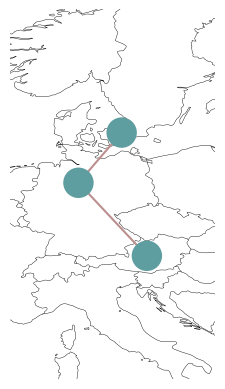

In [36]:
n.plot(bus_sizes=1, margin=1)

In [37]:

# Co2 Cap
CO2_limit = (152 + 4.9 + 6.0) #MtCO2 just electricity

n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant= CO2_limit * 1000000, #152MtCO2 for GE + 6.0 for DK (https://www.nowtricity.com/country/denmark/) + 4.9 for AT (https://www.nowtricity.com/country/austria)
)


Index(['CO2Limit'], dtype='object')

In [38]:
n.optimize(solver_name='gurobi')


Index(['DEU', 'DNK', 'AUT'], dtype='object', name='Bus')
Index(['DEU-DNK', 'DEU-AUT'], dtype='object', name='Line')
Index(['DEU', 'DNK', 'AUT'], dtype='object', name='Bus')
Index(['DEU-DNK', 'DEU-AUT'], dtype='object', name='Line')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.96it/s]
INFO:linopy.io: Writing time: 3.2s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-1djk1elb.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-1djk1elb.lp


Reading time = 0.84 seconds


INFO:gurobipy:Reading time = 0.84 seconds


obj: 499336 rows, 227775 columns, 1012000 nonzeros


INFO:gurobipy:obj: 499336 rows, 227775 columns, 1012000 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 499336 rows, 227775 columns and 1012000 nonzeros


INFO:gurobipy:Optimize a model with 499336 rows, 227775 columns and 1012000 nonzeros


Model fingerprint: 0xa45e9cb0


INFO:gurobipy:Model fingerprint: 0xa45e9cb0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+03]


INFO:gurobipy:  Matrix range     [1e-03, 2e+03]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [1e+03, 6e+03]


INFO:gurobipy:  Bounds range     [1e+03, 6e+03]


  RHS range        [1e+03, 2e+08]


INFO:gurobipy:  RHS range        [1e+03, 2e+08]


Presolve removed 249469 rows and 12934 columns


INFO:gurobipy:Presolve removed 249469 rows and 12934 columns


Presolve time: 0.75s


INFO:gurobipy:Presolve time: 0.75s


Presolved: 249867 rows, 214841 columns, 749597 nonzeros


INFO:gurobipy:Presolved: 249867 rows, 214841 columns, 749597 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.18s


INFO:gurobipy:Ordering time: 0.18s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 15


INFO:gurobipy: Dense cols : 15


 AA' NZ     : 6.311e+05


INFO:gurobipy: AA' NZ     : 6.311e+05


 Factor NZ  : 4.485e+06 (roughly 220 MB of memory)


INFO:gurobipy: Factor NZ  : 4.485e+06 (roughly 220 MB of memory)


 Factor Ops : 9.751e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 9.751e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.05020884e+13 -4.54097143e+11  5.10e+10 0.00e+00  4.60e+09     2s


INFO:gurobipy:   0   1.05020884e+13 -4.54097143e+11  5.10e+10 0.00e+00  4.60e+09     2s


   1   1.36058692e+13 -1.55555053e+12  9.77e+09 3.20e+02  1.05e+09     2s


INFO:gurobipy:   1   1.36058692e+13 -1.55555053e+12  9.77e+09 3.20e+02  1.05e+09     2s


   2   1.10062055e+13 -1.55782459e+12  1.31e+09 6.89e+01  2.26e+08     2s


INFO:gurobipy:   2   1.10062055e+13 -1.55782459e+12  1.31e+09 6.89e+01  2.26e+08     2s


   3   4.47210853e+12 -8.74253439e+11  1.11e+08 8.32e+00  3.38e+07     3s


INFO:gurobipy:   3   4.47210853e+12 -8.74253439e+11  1.11e+08 8.32e+00  3.38e+07     3s


   4   2.07321038e+12 -2.91054862e+11  2.84e+07 1.18e+00  8.01e+06     3s


INFO:gurobipy:   4   2.07321038e+12 -2.91054862e+11  2.84e+07 1.18e+00  8.01e+06     3s


   5   8.31650308e+11 -6.34010708e+10  7.54e+06 1.42e-01  2.36e+06     4s


INFO:gurobipy:   5   8.31650308e+11 -6.34010708e+10  7.54e+06 1.42e-01  2.36e+06     4s


   6   2.56411368e+11 -1.36310689e+10  1.71e+06 3.54e-02  6.68e+05     4s


INFO:gurobipy:   6   2.56411368e+11 -1.36310689e+10  1.71e+06 3.54e-02  6.68e+05     4s


   7   1.33270299e+11  2.61250494e+09  7.32e+05 1.68e-02  3.16e+05     4s


INFO:gurobipy:   7   1.33270299e+11  2.61250494e+09  7.32e+05 1.68e-02  3.16e+05     4s


   8   9.07978950e+10  1.12293919e+10  4.12e+05 8.99e-03  1.90e+05     5s


INFO:gurobipy:   8   9.07978950e+10  1.12293919e+10  4.12e+05 8.99e-03  1.90e+05     5s


   9   6.84191456e+10  1.59629983e+10  2.64e+05 5.49e-03  1.25e+05     5s


INFO:gurobipy:   9   6.84191456e+10  1.59629983e+10  2.64e+05 5.49e-03  1.25e+05     5s


  10   5.53711728e+10  1.99287925e+10  1.79e+05 2.92e-03  8.37e+04     5s


INFO:gurobipy:  10   5.53711728e+10  1.99287925e+10  1.79e+05 2.92e-03  8.37e+04     5s


  11   4.85372771e+10  2.25328865e+10  1.33e+05 1.52e-03  6.12e+04     6s


INFO:gurobipy:  11   4.85372771e+10  2.25328865e+10  1.33e+05 1.52e-03  6.12e+04     6s


  12   4.18632912e+10  2.47658059e+10  8.65e+04 5.90e-04  4.01e+04     6s


INFO:gurobipy:  12   4.18632912e+10  2.47658059e+10  8.65e+04 5.90e-04  4.01e+04     6s


  13   3.82876015e+10  2.61859923e+10  6.16e+04 1.90e-04  2.84e+04     7s


INFO:gurobipy:  13   3.82876015e+10  2.61859923e+10  6.16e+04 1.90e-04  2.84e+04     7s


  14   3.55434174e+10  2.72882964e+10  4.13e+04 2.01e-09  1.93e+04     7s


INFO:gurobipy:  14   3.55434174e+10  2.72882964e+10  4.13e+04 2.01e-09  1.93e+04     7s


  15   3.52155827e+10  2.76853838e+10  3.87e+04 7.39e-10  1.76e+04     7s


INFO:gurobipy:  15   3.52155827e+10  2.76853838e+10  3.87e+04 7.39e-10  1.76e+04     7s


  16   3.49319156e+10  2.82063524e+10  3.66e+04 1.84e-10  1.57e+04     8s


INFO:gurobipy:  16   3.49319156e+10  2.82063524e+10  3.66e+04 1.84e-10  1.57e+04     8s


  17   3.35686172e+10  2.84880479e+10  2.66e+04 5.00e-10  1.19e+04     8s


INFO:gurobipy:  17   3.35686172e+10  2.84880479e+10  2.66e+04 5.00e-10  1.19e+04     8s


  18   3.28142061e+10  2.85214761e+10  2.09e+04 1.48e-09  1.00e+04     8s


INFO:gurobipy:  18   3.28142061e+10  2.85214761e+10  2.09e+04 1.48e-09  1.00e+04     8s


  19   3.25862698e+10  2.86465418e+10  1.92e+04 5.96e-10  9.22e+03     9s


INFO:gurobipy:  19   3.25862698e+10  2.86465418e+10  1.92e+04 5.96e-10  9.22e+03     9s


  20   3.23981544e+10  2.88562401e+10  1.79e+04 3.81e-10  8.28e+03     9s


INFO:gurobipy:  20   3.23981544e+10  2.88562401e+10  1.79e+04 3.81e-10  8.28e+03     9s


  21   3.21449813e+10  2.90098870e+10  1.61e+04 1.12e-09  7.33e+03    10s


INFO:gurobipy:  21   3.21449813e+10  2.90098870e+10  1.61e+04 1.12e-09  7.33e+03    10s


  22   3.20405548e+10  2.90992013e+10  1.52e+04 5.44e-10  6.88e+03    10s


INFO:gurobipy:  22   3.20405548e+10  2.90992013e+10  1.52e+04 5.44e-10  6.88e+03    10s


  23   3.18398890e+10  2.92898752e+10  1.36e+04 7.35e-10  5.96e+03    10s


INFO:gurobipy:  23   3.18398890e+10  2.92898752e+10  1.36e+04 7.35e-10  5.96e+03    10s


  24   3.15941535e+10  2.93812128e+10  1.13e+04 9.01e-10  5.17e+03    11s


INFO:gurobipy:  24   3.15941535e+10  2.93812128e+10  1.13e+04 9.01e-10  5.17e+03    11s


  25   3.12103883e+10  2.95418411e+10  7.84e+03 6.54e-09  3.90e+03    11s


INFO:gurobipy:  25   3.12103883e+10  2.95418411e+10  7.84e+03 6.54e-09  3.90e+03    11s


  26   3.10202182e+10  2.96534220e+10  6.32e+03 1.31e-08  3.20e+03    12s


INFO:gurobipy:  26   3.10202182e+10  2.96534220e+10  6.32e+03 1.31e-08  3.20e+03    12s


  27   3.09072214e+10  2.97253856e+10  5.19e+03 1.66e-08  2.76e+03    12s


INFO:gurobipy:  27   3.09072214e+10  2.97253856e+10  5.19e+03 1.66e-08  2.76e+03    12s


  28   3.07287715e+10  2.98456939e+10  3.55e+03 2.01e-08  2.06e+03    12s


INFO:gurobipy:  28   3.07287715e+10  2.98456939e+10  3.55e+03 2.01e-08  2.06e+03    12s


  29   3.06592105e+10  2.98952592e+10  3.01e+03 1.97e-08  1.79e+03    13s


INFO:gurobipy:  29   3.06592105e+10  2.98952592e+10  3.01e+03 1.97e-08  1.79e+03    13s


  30   3.06229101e+10  2.99533316e+10  2.74e+03 1.69e-08  1.57e+03    13s


INFO:gurobipy:  30   3.06229101e+10  2.99533316e+10  2.74e+03 1.69e-08  1.57e+03    13s


  31   3.05556573e+10  2.99776144e+10  2.21e+03 1.55e-08  1.35e+03    14s


INFO:gurobipy:  31   3.05556573e+10  2.99776144e+10  2.21e+03 1.55e-08  1.35e+03    14s


  32   3.05269253e+10  3.00085279e+10  1.96e+03 1.57e-08  1.21e+03    14s


INFO:gurobipy:  32   3.05269253e+10  3.00085279e+10  1.96e+03 1.57e-08  1.21e+03    14s


  33   3.05044878e+10  3.00277209e+10  1.74e+03 1.55e-08  1.11e+03    15s


INFO:gurobipy:  33   3.05044878e+10  3.00277209e+10  1.74e+03 1.55e-08  1.11e+03    15s


  34   3.04427004e+10  3.00773769e+10  1.17e+03 1.37e-08  8.54e+02    15s


INFO:gurobipy:  34   3.04427004e+10  3.00773769e+10  1.17e+03 1.37e-08  8.54e+02    15s


  35   3.04203346e+10  3.01380086e+10  9.87e+02 1.30e-08  6.60e+02    15s


INFO:gurobipy:  35   3.04203346e+10  3.01380086e+10  9.87e+02 1.30e-08  6.60e+02    15s


  36   3.04056782e+10  3.01615413e+10  8.75e+02 1.27e-08  5.71e+02    16s


INFO:gurobipy:  36   3.04056782e+10  3.01615413e+10  8.75e+02 1.27e-08  5.71e+02    16s


  37   3.03860628e+10  3.01836065e+10  7.34e+02 1.69e-08  4.73e+02    16s


INFO:gurobipy:  37   3.03860628e+10  3.01836065e+10  7.34e+02 1.69e-08  4.73e+02    16s


  38   3.03827665e+10  3.01899761e+10  7.08e+02 1.76e-08  4.51e+02    16s


INFO:gurobipy:  38   3.03827665e+10  3.01899761e+10  7.08e+02 1.76e-08  4.51e+02    16s


  39   3.03729429e+10  3.02137129e+10  6.29e+02 2.82e-08  3.72e+02    17s


INFO:gurobipy:  39   3.03729429e+10  3.02137129e+10  6.29e+02 2.82e-08  3.72e+02    17s


  40   3.03629399e+10  3.02318616e+10  5.40e+02 1.72e-08  3.06e+02    17s


INFO:gurobipy:  40   3.03629399e+10  3.02318616e+10  5.40e+02 1.72e-08  3.06e+02    17s


  41   3.03479593e+10  3.02398446e+10  4.21e+02 1.43e-08  2.53e+02    18s


INFO:gurobipy:  41   3.03479593e+10  3.02398446e+10  4.21e+02 1.43e-08  2.53e+02    18s


  42   3.03358530e+10  3.02471927e+10  3.20e+02 1.02e-08  2.07e+02    18s


INFO:gurobipy:  42   3.03358530e+10  3.02471927e+10  3.20e+02 1.02e-08  2.07e+02    18s


  43   3.03339052e+10  3.02561392e+10  3.04e+02 1.12e-08  1.82e+02    18s


INFO:gurobipy:  43   3.03339052e+10  3.02561392e+10  3.04e+02 1.12e-08  1.82e+02    18s


  44   3.03282599e+10  3.02589228e+10  2.59e+02 1.03e-08  1.62e+02    19s


INFO:gurobipy:  44   3.03282599e+10  3.02589228e+10  2.59e+02 1.03e-08  1.62e+02    19s


  45   3.03247766e+10  3.02622615e+10  2.29e+02 8.34e-09  1.46e+02    19s


INFO:gurobipy:  45   3.03247766e+10  3.02622615e+10  2.29e+02 8.34e-09  1.46e+02    19s


  46   3.03194853e+10  3.02668670e+10  1.88e+02 2.94e-09  1.23e+02    19s


INFO:gurobipy:  46   3.03194853e+10  3.02668670e+10  1.88e+02 2.94e-09  1.23e+02    19s


  47   3.03143351e+10  3.02686881e+10  1.46e+02 3.37e-09  1.07e+02    20s


INFO:gurobipy:  47   3.03143351e+10  3.02686881e+10  1.46e+02 3.37e-09  1.07e+02    20s


  48   3.03117980e+10  3.02734310e+10  1.26e+02 3.41e-09  8.97e+01    20s


INFO:gurobipy:  48   3.03117980e+10  3.02734310e+10  1.26e+02 3.41e-09  8.97e+01    20s


  49   3.03102531e+10  3.02760147e+10  1.13e+02 3.23e-09  8.00e+01    21s


INFO:gurobipy:  49   3.03102531e+10  3.02760147e+10  1.13e+02 3.23e-09  8.00e+01    21s


  50   3.03089876e+10  3.02775640e+10  1.03e+02 8.64e-09  7.35e+01    21s


INFO:gurobipy:  50   3.03089876e+10  3.02775640e+10  1.03e+02 8.64e-09  7.35e+01    21s


  51   3.03070646e+10  3.02802209e+10  8.87e+01 1.28e-08  6.27e+01    21s


INFO:gurobipy:  51   3.03070646e+10  3.02802209e+10  8.87e+01 1.28e-08  6.27e+01    21s


  52   3.03067719e+10  3.02811311e+10  8.63e+01 1.28e-08  5.99e+01    22s


INFO:gurobipy:  52   3.03067719e+10  3.02811311e+10  8.63e+01 1.28e-08  5.99e+01    22s


  53   3.03060331e+10  3.02820146e+10  8.09e+01 1.20e-08  5.61e+01    22s


INFO:gurobipy:  53   3.03060331e+10  3.02820146e+10  8.09e+01 1.20e-08  5.61e+01    22s


  54   3.03048599e+10  3.02825782e+10  7.16e+01 1.17e-08  5.21e+01    22s


INFO:gurobipy:  54   3.03048599e+10  3.02825782e+10  7.16e+01 1.17e-08  5.21e+01    22s


  55   3.03042079e+10  3.02835049e+10  6.67e+01 1.11e-08  4.84e+01    22s


INFO:gurobipy:  55   3.03042079e+10  3.02835049e+10  6.67e+01 1.11e-08  4.84e+01    22s


  56   3.03034141e+10  3.02843671e+10  6.09e+01 1.50e-08  4.45e+01    23s


INFO:gurobipy:  56   3.03034141e+10  3.02843671e+10  6.09e+01 1.50e-08  4.45e+01    23s


  57   3.03028900e+10  3.02853236e+10  5.69e+01 2.00e-08  4.11e+01    23s


INFO:gurobipy:  57   3.03028900e+10  3.02853236e+10  5.69e+01 2.00e-08  4.11e+01    23s


  58   3.03021586e+10  3.02857475e+10  5.16e+01 1.59e-08  3.84e+01    24s


INFO:gurobipy:  58   3.03021586e+10  3.02857475e+10  5.16e+01 1.59e-08  3.84e+01    24s


  59   3.03016163e+10  3.02864815e+10  4.77e+01 1.49e-08  3.54e+01    24s


INFO:gurobipy:  59   3.03016163e+10  3.02864815e+10  4.77e+01 1.49e-08  3.54e+01    24s


  60   3.03010853e+10  3.02875228e+10  4.39e+01 2.81e-08  3.17e+01    24s


INFO:gurobipy:  60   3.03010853e+10  3.02875228e+10  4.39e+01 2.81e-08  3.17e+01    24s


  61   3.03005123e+10  3.02878034e+10  3.96e+01 3.33e-08  2.97e+01    25s


INFO:gurobipy:  61   3.03005123e+10  3.02878034e+10  3.96e+01 3.33e-08  2.97e+01    25s


  62   3.03000319e+10  3.02881892e+10  3.56e+01 3.21e-08  2.77e+01    25s


INFO:gurobipy:  62   3.03000319e+10  3.02881892e+10  3.56e+01 3.21e-08  2.77e+01    25s


  63   3.02995966e+10  3.02888955e+10  3.20e+01 3.33e-08  2.50e+01    25s


INFO:gurobipy:  63   3.02995966e+10  3.02888955e+10  3.20e+01 3.33e-08  2.50e+01    25s


  64   3.02993291e+10  3.02893132e+10  3.00e+01 3.17e-08  2.34e+01    26s


INFO:gurobipy:  64   3.02993291e+10  3.02893132e+10  3.00e+01 3.17e-08  2.34e+01    26s


  65   3.02990548e+10  3.02897202e+10  2.79e+01 3.26e-08  2.18e+01    26s


INFO:gurobipy:  65   3.02990548e+10  3.02897202e+10  2.79e+01 3.26e-08  2.18e+01    26s


  66   3.02988390e+10  3.02901990e+10  2.61e+01 3.77e-08  2.02e+01    26s


INFO:gurobipy:  66   3.02988390e+10  3.02901990e+10  2.61e+01 3.77e-08  2.02e+01    26s


  67   3.02987102e+10  3.02904078e+10  2.49e+01 4.12e-08  1.94e+01    27s


INFO:gurobipy:  67   3.02987102e+10  3.02904078e+10  2.49e+01 4.12e-08  1.94e+01    27s


  68   3.02983517e+10  3.02907986e+10  2.20e+01 3.71e-08  1.77e+01    27s


INFO:gurobipy:  68   3.02983517e+10  3.02907986e+10  2.20e+01 3.71e-08  1.77e+01    27s


  69   3.02982182e+10  3.02909631e+10  2.10e+01 4.67e-08  1.70e+01    27s


INFO:gurobipy:  69   3.02982182e+10  3.02909631e+10  2.10e+01 4.67e-08  1.70e+01    27s


  70   3.02980517e+10  3.02911705e+10  1.97e+01 5.83e-08  1.61e+01    28s


INFO:gurobipy:  70   3.02980517e+10  3.02911705e+10  1.97e+01 5.83e-08  1.61e+01    28s


  71   3.02978603e+10  3.02915632e+10  1.83e+01 6.78e-08  1.47e+01    28s


INFO:gurobipy:  71   3.02978603e+10  3.02915632e+10  1.83e+01 6.78e-08  1.47e+01    28s


  72   3.02976690e+10  3.02918854e+10  1.67e+01 7.69e-08  1.35e+01    28s


INFO:gurobipy:  72   3.02976690e+10  3.02918854e+10  1.67e+01 7.69e-08  1.35e+01    28s


  73   3.02974746e+10  3.02921093e+10  1.52e+01 1.15e-07  1.25e+01    29s


INFO:gurobipy:  73   3.02974746e+10  3.02921093e+10  1.52e+01 1.15e-07  1.25e+01    29s


  74   3.02973063e+10  3.02924157e+10  1.38e+01 1.19e-07  1.14e+01    29s


INFO:gurobipy:  74   3.02973063e+10  3.02924157e+10  1.38e+01 1.19e-07  1.14e+01    29s


  75   3.02971577e+10  3.02924659e+10  1.26e+01 1.10e-07  1.10e+01    30s


INFO:gurobipy:  75   3.02971577e+10  3.02924659e+10  1.26e+01 1.10e-07  1.10e+01    30s


  76   3.02970196e+10  3.02927061e+10  1.16e+01 1.18e-07  1.01e+01    30s


INFO:gurobipy:  76   3.02970196e+10  3.02927061e+10  1.16e+01 1.18e-07  1.01e+01    30s


  77   3.02968393e+10  3.02929473e+10  1.05e+01 1.64e-07  9.10e+00    30s


INFO:gurobipy:  77   3.02968393e+10  3.02929473e+10  1.05e+01 1.64e-07  9.10e+00    30s


  78   3.02967431e+10  3.02931187e+10  9.75e+00 1.52e-07  8.47e+00    31s


INFO:gurobipy:  78   3.02967431e+10  3.02931187e+10  9.75e+00 1.52e-07  8.47e+00    31s


  79   3.02966649e+10  3.02932493e+10  9.15e+00 1.80e-07  7.99e+00    31s


INFO:gurobipy:  79   3.02966649e+10  3.02932493e+10  9.15e+00 1.80e-07  7.99e+00    31s


  80   3.02966427e+10  3.02932936e+10  8.98e+00 1.84e-07  7.83e+00    31s


INFO:gurobipy:  80   3.02966427e+10  3.02932936e+10  8.98e+00 1.84e-07  7.83e+00    31s


  81   3.02965895e+10  3.02933855e+10  8.59e+00 1.93e-07  7.49e+00    32s


INFO:gurobipy:  81   3.02965895e+10  3.02933855e+10  8.59e+00 1.93e-07  7.49e+00    32s


  82   3.02965191e+10  3.02935054e+10  8.07e+00 2.26e-07  7.05e+00    32s


INFO:gurobipy:  82   3.02965191e+10  3.02935054e+10  8.07e+00 2.26e-07  7.05e+00    32s


  83   3.02964098e+10  3.02936062e+10  7.19e+00 2.67e-07  6.56e+00    32s


INFO:gurobipy:  83   3.02964098e+10  3.02936062e+10  7.19e+00 2.67e-07  6.56e+00    32s


  84   3.02963250e+10  3.02938244e+10  6.42e+00 1.20e-07  5.85e+00    33s


INFO:gurobipy:  84   3.02963250e+10  3.02938244e+10  6.42e+00 1.20e-07  5.85e+00    33s


  85   3.02961766e+10  3.02940258e+10  5.23e+00 1.01e-07  5.03e+00    33s


INFO:gurobipy:  85   3.02961766e+10  3.02940258e+10  5.23e+00 1.01e-07  5.03e+00    33s


  86   3.02960737e+10  3.02941410e+10  4.41e+00 1.02e-07  4.52e+00    33s


INFO:gurobipy:  86   3.02960737e+10  3.02941410e+10  4.41e+00 1.02e-07  4.52e+00    33s


  87   3.02960183e+10  3.02941894e+10  3.98e+00 1.04e-07  4.28e+00    34s


INFO:gurobipy:  87   3.02960183e+10  3.02941894e+10  3.98e+00 1.04e-07  4.28e+00    34s


  88   3.02959591e+10  3.02942430e+10  3.57e+00 1.53e-07  4.01e+00    34s


INFO:gurobipy:  88   3.02959591e+10  3.02942430e+10  3.57e+00 1.53e-07  4.01e+00    34s


  89   3.02959402e+10  3.02942756e+10  3.46e+00 2.16e-07  3.89e+00    34s


INFO:gurobipy:  89   3.02959402e+10  3.02942756e+10  3.46e+00 2.16e-07  3.89e+00    34s


  90   3.02959037e+10  3.02943609e+10  3.23e+00 1.95e-07  3.61e+00    35s


INFO:gurobipy:  90   3.02959037e+10  3.02943609e+10  3.23e+00 1.95e-07  3.61e+00    35s


  91   3.02958735e+10  3.02944403e+10  2.94e+00 1.84e-07  3.35e+00    35s


INFO:gurobipy:  91   3.02958735e+10  3.02944403e+10  2.94e+00 1.84e-07  3.35e+00    35s


  92   3.02958184e+10  3.02945451e+10  2.50e+00 1.68e-07  2.98e+00    35s


INFO:gurobipy:  92   3.02958184e+10  3.02945451e+10  2.50e+00 1.68e-07  2.98e+00    35s


  93   3.02957727e+10  3.02946038e+10  2.15e+00 1.78e-07  2.73e+00    36s


INFO:gurobipy:  93   3.02957727e+10  3.02946038e+10  2.15e+00 1.78e-07  2.73e+00    36s


  94   3.02957453e+10  3.02946595e+10  1.92e+00 2.27e-07  2.54e+00    36s


INFO:gurobipy:  94   3.02957453e+10  3.02946595e+10  1.92e+00 2.27e-07  2.54e+00    36s


  95   3.02957184e+10  3.02947422e+10  1.72e+00 4.12e-07  2.28e+00    36s


INFO:gurobipy:  95   3.02957184e+10  3.02947422e+10  1.72e+00 4.12e-07  2.28e+00    36s


  96   3.02956856e+10  3.02948111e+10  1.47e+00 3.21e-06  2.05e+00    37s


INFO:gurobipy:  96   3.02956856e+10  3.02948111e+10  1.47e+00 3.21e-06  2.05e+00    37s


  97   3.02956729e+10  3.02948640e+10  1.37e+00 6.67e-07  1.89e+00    37s


INFO:gurobipy:  97   3.02956729e+10  3.02948640e+10  1.37e+00 6.67e-07  1.89e+00    37s


  98   3.02956486e+10  3.02949660e+10  1.15e+00 5.09e-07  1.60e+00    37s


INFO:gurobipy:  98   3.02956486e+10  3.02949660e+10  1.15e+00 5.09e-07  1.60e+00    37s


  99   3.02956458e+10  3.02950643e+10  1.12e+00 2.01e-06  1.36e+00    38s


INFO:gurobipy:  99   3.02956458e+10  3.02950643e+10  1.12e+00 2.01e-06  1.36e+00    38s


 100   3.02956327e+10  3.02951320e+10  1.02e+00 1.40e-06  1.17e+00    38s


INFO:gurobipy: 100   3.02956327e+10  3.02951320e+10  1.02e+00 1.40e-06  1.17e+00    38s


 101   3.02956219e+10  3.02951418e+10  9.32e-01 2.06e-06  1.12e+00    39s


INFO:gurobipy: 101   3.02956219e+10  3.02951418e+10  9.32e-01 2.06e-06  1.12e+00    39s


 102   3.02956018e+10  3.02952030e+10  7.83e-01 1.75e-06  9.33e-01    39s


INFO:gurobipy: 102   3.02956018e+10  3.02952030e+10  7.83e-01 1.75e-06  9.33e-01    39s


 103   3.02955999e+10  3.02952305e+10  7.47e-01 2.26e-06  8.64e-01    39s


INFO:gurobipy: 103   3.02955999e+10  3.02952305e+10  7.47e-01 2.26e-06  8.64e-01    39s


 104   3.02955802e+10  3.02953170e+10  6.04e-01 3.08e-06  6.15e-01    40s


INFO:gurobipy: 104   3.02955802e+10  3.02953170e+10  6.04e-01 3.08e-06  6.15e-01    40s


 105   3.02955790e+10  3.02953206e+10  5.73e-01 3.06e-06  6.04e-01    40s


INFO:gurobipy: 105   3.02955790e+10  3.02953206e+10  5.73e-01 3.06e-06  6.04e-01    40s


 106   3.02955594e+10  3.02953370e+10  4.29e-01 4.39e-06  5.20e-01    40s


INFO:gurobipy: 106   3.02955594e+10  3.02953370e+10  4.29e-01 4.39e-06  5.20e-01    40s


 107   3.02955498e+10  3.02953835e+10  3.58e-01 5.17e-06  3.89e-01    40s


INFO:gurobipy: 107   3.02955498e+10  3.02953835e+10  3.58e-01 5.17e-06  3.89e-01    40s


 108   3.02955414e+10  3.02953925e+10  2.90e-01 4.79e-06  3.48e-01    41s


INFO:gurobipy: 108   3.02955414e+10  3.02953925e+10  2.90e-01 4.79e-06  3.48e-01    41s


 109   3.02955334e+10  3.02954095e+10  2.28e-01 4.07e-06  2.90e-01    41s


INFO:gurobipy: 109   3.02955334e+10  3.02954095e+10  2.28e-01 4.07e-06  2.90e-01    41s


 110   3.02955290e+10  3.02954234e+10  1.94e-01 3.32e-06  2.47e-01    42s


INFO:gurobipy: 110   3.02955290e+10  3.02954234e+10  1.94e-01 3.32e-06  2.47e-01    42s


 111   3.02955084e+10  3.02954558e+10  1.16e-05 1.97e-06  1.23e-01    42s


INFO:gurobipy: 111   3.02955084e+10  3.02954558e+10  1.16e-05 1.97e-06  1.23e-01    42s


 112   3.02955078e+10  3.02954624e+10  1.04e-05 1.67e-06  1.06e-01    42s


INFO:gurobipy: 112   3.02955078e+10  3.02954624e+10  1.04e-05 1.67e-06  1.06e-01    42s


 113   3.02955071e+10  3.02954912e+10  8.70e-06 4.56e-07  3.71e-02    43s


INFO:gurobipy: 113   3.02955071e+10  3.02954912e+10  8.70e-06 4.56e-07  3.71e-02    43s


 114   3.02955046e+10  3.02955009e+10  9.90e-06 6.76e-08  8.69e-03    43s


INFO:gurobipy: 114   3.02955046e+10  3.02955009e+10  9.90e-06 6.76e-08  8.69e-03    43s


 115   3.02955043e+10  3.02955015e+10  2.07e-06 5.38e-08  6.62e-03    43s


INFO:gurobipy: 115   3.02955043e+10  3.02955015e+10  2.07e-06 5.38e-08  6.62e-03    43s


 116   3.02955043e+10  3.02955017e+10  1.81e-06 5.01e-08  6.17e-03    44s


INFO:gurobipy: 116   3.02955043e+10  3.02955017e+10  1.81e-06 5.01e-08  6.17e-03    44s


 117   3.02955043e+10  3.02955025e+10  1.70e-06 3.44e-08  4.29e-03    44s


INFO:gurobipy: 117   3.02955043e+10  3.02955025e+10  1.70e-06 3.44e-08  4.29e-03    44s


 118   3.02955043e+10  3.02955042e+10  1.30e-06 1.61e-09  3.30e-04    45s


INFO:gurobipy: 118   3.02955043e+10  3.02955042e+10  1.30e-06 1.61e-09  3.30e-04    45s


 119   3.02955043e+10  3.02955042e+10  7.09e-05 3.32e-09  7.23e-05    45s


INFO:gurobipy: 119   3.02955043e+10  3.02955042e+10  7.09e-05 3.32e-09  7.23e-05    45s


 120   3.02955043e+10  3.02955043e+10  9.20e-07 1.58e-08  3.04e-07    45s


INFO:gurobipy: 120   3.02955043e+10  3.02955043e+10  9.20e-07 1.58e-08  3.04e-07    45s


 121   3.02955043e+10  3.02955043e+10  3.65e-05 1.05e-08  1.43e-10    46s


INFO:gurobipy: 121   3.02955043e+10  3.02955043e+10  3.65e-05 1.05e-08  1.43e-10    46s


INFO:gurobipy:


Barrier solved model in 121 iterations and 45.63 seconds (19.79 work units)


INFO:gurobipy:Barrier solved model in 121 iterations and 45.63 seconds (19.79 work units)


Optimal objective 3.02955043e+10


INFO:gurobipy:Optimal objective 3.02955043e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   62097 DPushes remaining with DInf 0.0000000e+00                46s


INFO:gurobipy:   62097 DPushes remaining with DInf 0.0000000e+00                46s


       0 DPushes remaining with DInf 0.0000000e+00                47s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                47s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   29854 PPushes remaining with PInf 0.0000000e+00                47s


INFO:gurobipy:   29854 PPushes remaining with PInf 0.0000000e+00                47s


   25931 PPushes remaining with PInf 0.0000000e+00                51s


INFO:gurobipy:   25931 PPushes remaining with PInf 0.0000000e+00                51s


   20434 PPushes remaining with PInf 0.0000000e+00                57s


INFO:gurobipy:   20434 PPushes remaining with PInf 0.0000000e+00                57s


   19714 PPushes remaining with PInf 0.0000000e+00                60s


INFO:gurobipy:   19714 PPushes remaining with PInf 0.0000000e+00                60s


   16745 PPushes remaining with PInf 0.0000000e+00                66s


INFO:gurobipy:   16745 PPushes remaining with PInf 0.0000000e+00                66s


   14285 PPushes remaining with PInf 0.0000000e+00                70s


INFO:gurobipy:   14285 PPushes remaining with PInf 0.0000000e+00                70s


   11741 PPushes remaining with PInf 0.0000000e+00                76s


INFO:gurobipy:   11741 PPushes remaining with PInf 0.0000000e+00                76s


    9788 PPushes remaining with PInf 0.0000000e+00                80s


INFO:gurobipy:    9788 PPushes remaining with PInf 0.0000000e+00                80s


    7533 PPushes remaining with PInf 0.0000000e+00                85s


INFO:gurobipy:    7533 PPushes remaining with PInf 0.0000000e+00                85s


    5579 PPushes remaining with PInf 0.0000000e+00                90s


INFO:gurobipy:    5579 PPushes remaining with PInf 0.0000000e+00                90s


    3087 PPushes remaining with PInf 0.0000000e+00                96s


INFO:gurobipy:    3087 PPushes remaining with PInf 0.0000000e+00                96s


    1160 PPushes remaining with PInf 0.0000000e+00               100s


INFO:gurobipy:    1160 PPushes remaining with PInf 0.0000000e+00               100s


       0 PPushes remaining with PInf 0.0000000e+00               104s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               104s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.5131626e-08    104s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.5131626e-08    104s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   59127    3.0295504e+10   0.000000e+00   3.000000e-06    105s


INFO:gurobipy:   59127    3.0295504e+10   0.000000e+00   3.000000e-06    105s


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


   59129    3.0295504e+10   0.000000e+00   0.000000e+00    106s


INFO:gurobipy:   59129    3.0295504e+10   0.000000e+00   0.000000e+00    106s


INFO:gurobipy:


Solved in 59129 iterations and 105.68 seconds (103.15 work units)


INFO:gurobipy:Solved in 59129 iterations and 105.68 seconds (103.15 work units)


Optimal objective  3.029550426e+10


INFO:gurobipy:Optimal objective  3.029550426e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 227775 primals, 499336 duals
Objective: 3.03e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [39]:
colors

{'onshore': 'blue',
 'offshore': 'darkblue',
 'pv': 'orange',
 'rooftop': 'yellow',
 'coal': 'brown',
 'OCGT': 'grey'}

onshore wind


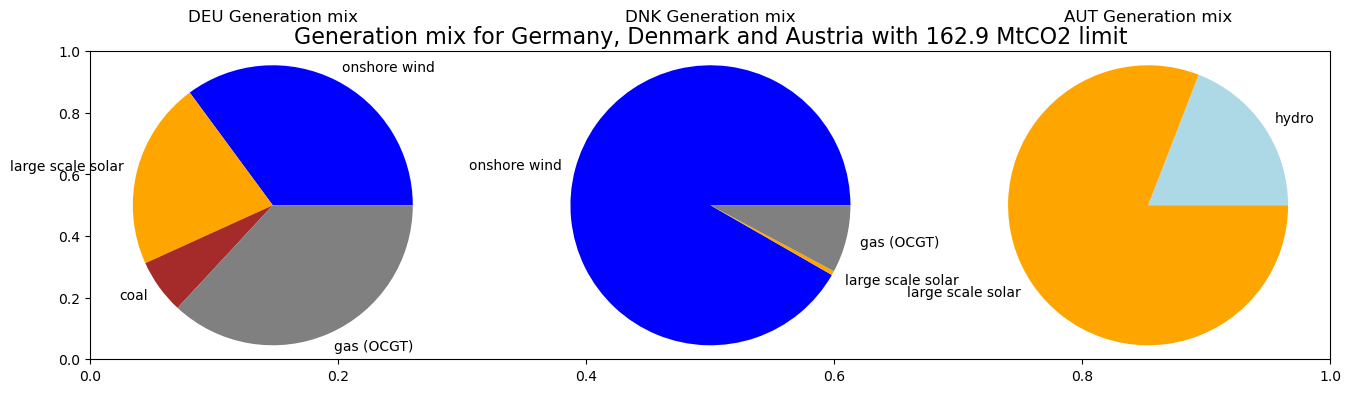

In [40]:
plt.figure(figsize=(16, 4))
plt.title(f'Generation mix for Germany, Denmark and Austria with {CO2_limit} MtCO2 limit', fontsize=16)
colors_all = {'onshore wind': 'blue',
               'offshore wind': 'darkblue',
               'large scale solar': 'orange',
               'rooftop solar': 'yellow',
               'coal': 'brown',
               'gas (OCGT)': 'grey',
               'hydro': 'lightblue'}


for country in countries:      
   if country == "DEU":
      labels = ['onshore wind',
               'offshore wind',
               'large scale solar',
               'coal',
               'gas (OCGT)']
      sizes = [n.generators_t.p[f'onshorewind{country}'].sum(),
                     n.generators_t.p[f'offshorewind{country}'].sum(),
                  n.generators_t.p[f'PV{country}'].sum(),
                     n.generators_t.p[f'coal{country}'].sum(),
                  n.generators_t.p[f'OCGT{country}'].sum()]
      labels = [labels[i] for i in range(len(labels)) if sizes[i] > 0]
      sizes = [x for x in sizes if x > 0]
      colors = [colors_all[label] for label in labels]



      plt.subplot(1, 3, 1)
      plt.pie(sizes,
            colors=colors,
            labels=labels,
            wedgeprops={'linewidth':0})
      plt.axis('equal')

      plt.title(f'{country} Generation mix', y=1.07)
   
   if country == "DNK":
      labels = ['onshore wind',
               'offshore wind',
               'large scale solar',
               'gas (OCGT)']
      sizes = [n.generators_t.p[f'onshorewind{country}'].sum(),
                     n.generators_t.p[f'offshorewind{country}'].sum(),
                  n.generators_t.p[f'PV{country}'].sum(),
                  n.generators_t.p[f'OCGT{country}'].sum()]

      labels = [labels[i] for i in range(len(labels)) if sizes[i] > 0]
      sizes = [x for x in sizes if x > 0]
      print(labels[0])
      colors = [colors_all[label] for label in labels]

      plt.subplot(1, 3, 2)
      plt.pie(sizes,
            colors=colors,
            labels=labels,
            wedgeprops={'linewidth':0})
      plt.axis('equal')

      plt.title(f'{country} Generation mix', y=1.07)

   
   if country == "AUT":
      labels = ['hydro',
               'large scale solar',
               'gas (OCGT)']
      sizes = [n.storage_units_t.p['hydroAUT'].sum(),
                  n.generators_t.p[f'PV{country}'].sum(),
                  n.generators_t.p[f'OCGT{country}'].sum()]

      labels = [labels[i] for i in range(len(labels)) if sizes[i] > 0]
      sizes = [x for x in sizes if x > 0]
      colors = [colors_all[label] for label in labels]

      plt.subplot(1, 3, 3)
      plt.pie(sizes,
            colors=colors,
            labels=labels,
            wedgeprops={'linewidth':0})
      plt.axis('equal')

      plt.title(f'{country} Generation mix', y=1.07)

      


<Axes: xlabel='snapshot'>

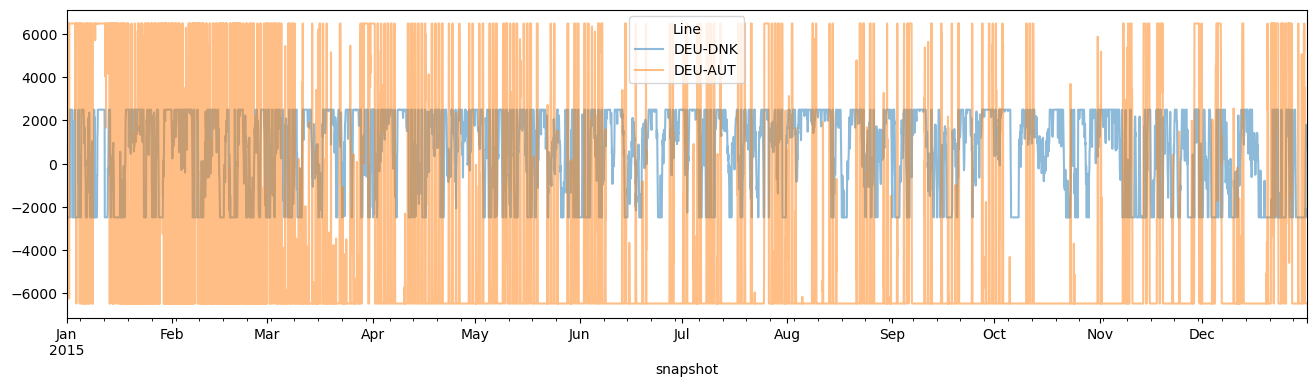

In [41]:
n.lines_t.p0.plot(figsize=(16, 4), alpha=0.5)